# Counterfactual model for Dedman *et al.* 2024 *Ecological roles and importance of sharks in the Anthropocene Ocean*

In [1]:
# Import packages
%matplotlib inline

import datetime
from itertools import product
import logging
import pickle
import pymc as pm
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import FuncFormatter, StrMethodFormatter
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import os
from math import isnan
#from sklearn.preprocessing import LabelEncoder
#from theano import tensor as tt
#from theano import shared
from collections import Counter
#import cmocean as co
import datetime as dt
import matplotlib as mpl
import arviz as az

In [2]:
# Helper function
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: [ b.index(x) if x in b else None for x in a ]
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(np.std(x)*2)

def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

def gelplot(pj,vector,posy,csize=40,lwd50=7,lwd95=1):
    if np.percentile(vector,2.5)<0 and 0<np.percentile(vector,97.5):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='grey')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='grey')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='grey')
    else:
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='black')
        pj.plot((np.percentile(vector,2.5),np.percentile(vector,97.5)),(posy,posy),linewidth=lwd95,c='black')
        pj.plot((np.percentile(vector,25),np.percentile(vector,75)),(posy,posy),linewidth=lwd50,c='black')
        
    if np.percentile(vector,25)<0 and 0<np.percentile(vector,75):
        pj.plot(np.median(vector),posy,'.',markersize=csize,c='white')

# Data

### Import FinPrint data

In [3]:
fpdata = pd.read_csv('/data/FinPrint_Set_Data.csv')
fpdata.columns.values

/var/folders/rr/py2vx3cs0cs7fvd2xtsr9h4m0000gn/T/ipykernel_8829/1728829785.py:1: DtypeWarning: Columns (23,26,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  fpdata = pd.read_csv('FinPrint_Set_Data.csv')


array(['region_name', 'region_id', 'location_name', 'location_code',
       'location_id', 'site_name', 'site_code', 'site_id', 'reef_name',
       'reef_type', 'reef_code', 'reef_id', 'trip_year', 'trip_code',
       'set_id', 'set_code', 'set_date', 'set_latitude', 'set_longitude',
       'maxn', 'functional_group', 'depth', 'drop_time', 'haul_time',
       'bait', 'bait_oiled', 'current_flow_estimated',
       'current_flow_instrumented', 'visibility', 'field_of_view',
       'substrate_relief_sd', 'substrate_relief_mean',
       'equipment_frame_type', 'equipment_camera',
       'equipment_stereo_camera', 'equipment_camera_height',
       'equipment_arm_length', 'ascidians', 'bleached_corals', 'bryozoa',
       'consolidated', 'crinoids', 'halimeda', 'hard_coral', 'hydrocoral',
       'hydroids', 'invertebrate_complex', 'macroalgae', 'mangrove',
       'seagrass', 'soft_coral', 'sponge', 'true_anemones',
       'unconsolidated', 'zoanthids', 'video_length_watched',
       'video_fi

In [4]:
fpdata.Shark_Protection_Status[fpdata.Shark_Protection_Status.isnull()].unique()

array([nan], dtype=object)

In [5]:
fpdata.site_type.unique()

array(['I', 'B', 'A', 'V', 'C', 'O'], dtype=object)

In [6]:
fpdata.shape

(171810, 87)

In [7]:
fpdata.Shark_fishing_restrictions.unique()

array(['Species; Gear; Entrants; Temporal', 'Area; Gear; Species',
       'Species; Bag; Entrants; Gear; Area', 'Area', 'Area; Entrants',
       'Gear', nan, 'Area; Bag; Entrants', 'Gear; Bag; Area', 'Bag; Area',
       'Entrants; Temporal; Gear; Species', 'Entrants; Area',
       'Temporal; Entrants; Species', 'Gear; Species',
       'Area; Entrants; Species', 'Entrants',
       'Temporal; Size; Bag; Entrants; Species', 'Species',
       'Size; Bag; Entrants; Species', 'Species; Gear', 'Species; Bag',
       'Gear; Bag; Species', 'Gear; Species; Bag',
       'Size; Bag; Entrants; Species; Gear', 'Size', 'Entrants; Gear'],
      dtype=object)

In [8]:
# Import location-scale data
ldata = pd.read_csv('/data/Location_Covariates.csv')
ldata.columns.values

array(['FP_location_id', 'FP_location_name', 'CoastLength',
       'FP_location_code', 'EPI', 'Ehealth', 'EcoVitality',
       'EPI_location_name', 'TradeHub', 'GINI_location_name', 'GINI_year',
       'GINI', 'HDI_location_name', 'HDI_year', 'HDI',
       'WGI_location_name', 'Voice_Accountability_year',
       'Voice_Accountability', 'Government_Effectiveness_year',
       'Government_Effectiveness', 'Regulatory_Quality_year',
       'Regulatory_Quality', 'Rule_of_Law_year', 'Rule_of_Law',
       'Control_Corruption_year', 'Control_Corruption',
       'GDP_location_name', 'GDP_year', 'GDP_per_capita_USD',
       'Population_location_name', 'Population_year', 'Population',
       'SAUP_EEZ_name', 'Catch_year', 'Total_catch_tonnes',
       'Total_catch_reported_only', 'Total_catch_value',
       'Reef_catch_tonnes', 'Reef_catch_value', 'Tuna_catch_tonnes',
       'Tuna_catch_value', 'Reefshark_catch_tonnes',
       'Reefshark_catch_value', 'Shark_catch_tonnes', 'Shark_catch_value',
   

In [9]:
critter = 'sharks'

In [10]:
fpdata['functional_group'].unique()

array(['apex', 'benthic_rover', 'guitar', 'pelagic', 'reef_meso',
       'large_ray', 'small_ray', 'coastal_rover', 'nocturnal_invader'],
      dtype=object)

In [11]:
# Grab only sharks
poo = fpdata[fpdata['functional_group'].isin(['reef_meso','apex','coastal_rover','benthic_rover', 'nocturnal_invader'])]

In [12]:
poo.functional_group.unique()

array(['apex', 'benthic_rover', 'reef_meso', 'coastal_rover',
       'nocturnal_invader'], dtype=object)

In [13]:
# Sum maxn's given set id's
tmp = poo.groupby(['set_id'], as_index=False)['maxn'].sum()
tmp.columns = ['set_id','MaxN_shark']

In [14]:
tmp.columns.values

array(['set_id', 'MaxN_shark'], dtype=object)

In [15]:
xdata = fpdata.merge(tmp, on=['set_id']).drop_duplicates(subset=['set_id'])

In [16]:
tmp.loc[tmp.set_id==2635].MaxN_shark

2075    9
Name: MaxN_shark, dtype: int64

In [17]:
np.shape(xdata)

(19090, 88)

In [18]:
xdata.columns

Index(['region_name', 'region_id', 'location_name', 'location_code',
       'location_id', 'site_name', 'site_code', 'site_id', 'reef_name',
       'reef_type', 'reef_code', 'reef_id', 'trip_year', 'trip_code', 'set_id',
       'set_code', 'set_date', 'set_latitude', 'set_longitude', 'maxn',
       'functional_group', 'depth', 'drop_time', 'haul_time', 'bait',
       'bait_oiled', 'current_flow_estimated', 'current_flow_instrumented',
       'visibility', 'field_of_view', 'substrate_relief_sd',
       'substrate_relief_mean', 'equipment_frame_type', 'equipment_camera',
       'equipment_stereo_camera', 'equipment_camera_height',
       'equipment_arm_length', 'ascidians', 'bleached_corals', 'bryozoa',
       'consolidated', 'crinoids', 'halimeda', 'hard_coral', 'hydrocoral',
       'hydroids', 'invertebrate_complex', 'macroalgae', 'mangrove',
       'seagrass', 'soft_coral', 'sponge', 'true_anemones', 'unconsolidated',
       'zoanthids', 'video_length_watched', 'video_filename', 'vide

In [19]:
# Break out Australia IOT and Dutch Antilles Leeward

xdata.location_name[xdata.site_name=='Ashmore'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Rowley Shoals'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Scott Reef'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Houtman Abrolhos'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Cocos-Keeling'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Christmas Island'] = 'Australia IOT'
xdata.location_name[xdata.site_name=='Pedro Bank'] = 'Jamaica PB'
xdata.location_name[xdata.site_name=='Cayo Serranilla'] = 'Columbia SF'
xdata.location_name[xdata.site_name=='Old Providence Island'] = 'Columbia SF'

xdata.location_name[xdata.location_name=='Saudi Arabia'] = 'Saudi Arabia-Red Sea'
xdata.location_name[xdata.location_name=='British West Indies '] = 'Montserrat'
ldata.FP_location_name[ldata.FP_location_name=='Saudi Arabia'] = 'Saudi Arabia-Red Sea'
ldata.FP_location_name[ldata.FP_location_name=='British West Indies '] = 'Montserrat' 

xdata.location_name[xdata.site_name=='Aruba'] = 'Dutch Antilles Leeward'
xdata.location_name[xdata.site_name=='Bonaire'] = 'Dutch Antilles Leeward'
xdata.location_name[xdata.site_name=='Curacao'] = 'Dutch Antilles Leeward'
xdata.location_name[xdata.site_name=='Saba'] = 'Dutch Antilles Windward'
xdata.location_name[xdata.site_name=='Saba Bank'] = 'Dutch Antilles Windward'
xdata.location_name[xdata.site_name=='St Eustatius'] = 'Dutch Antilles Windward'
xdata.location_name[xdata.site_name=='St Maarten'] = 'Dutch Antilles Windward'


/var/folders/rr/py2vx3cs0cs7fvd2xtsr9h4m0000gn/T/ipykernel_8829/2589257217.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xdata.location_name[xdata.site_name=='Rowley Shoals'] = 'Australia IOT'
/var/folders/rr/py2vx3cs0cs7fvd2xtsr9h4m0000gn/T/ipykernel_8829/2589257217.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xdata.location_name[xdata.site_name=='Scott Reef'] = 'Australia IOT'
/var/folders/rr/py2vx3cs0cs7fvd2xtsr9h4m0000gn/T/ipykernel_8829/2589257217.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

In [20]:
xdata.location_name.unique()

array(['USA-Western Atlantic', 'Bahamas', 'Australia-Pacific',
       'Australia IOT', 'Maldives', 'Malaysia', 'Solomon Islands',
       'Indonesia', 'Palau', 'American Samoa', 'New Caledonia', 'Belize',
       'Jamaica', 'Trinidad and Tobago', 'Vanuatu', 'British West Indies',
       'Fiji', 'Colombia', 'Australia-Indian Ocean', 'South Africa',
       'Mozambique', 'Niue', 'Japan', 'Seychelles', 'Taiwan', 'Kiribati',
       'Qatar', 'Federated States of Micronesia', 'Vietnam',
       'Philippines', 'French Polynesia', 'Samoa', 'Turks and Caicos',
       'Antigua and Barbuda', 'Barbados', 'Brazil', 'Columbia SF',
       'Jamaica PB', 'Mayotte', 'USA-Pacific', 'Sri Lanka', 'Tanzania',
       'Papua New Guinea', 'Tonga', 'New Zealand', 'India', 'Kenya',
       'Dutch Antilles Windward', 'Madagascar', 'Saudi Arabia-Red Sea',
       'Guam', 'Cook Islands', 'Dominican Republic', 'French West Indies',
       'Dutch Antilles Leeward', 'Cuba', 'Bermuda', 'Puerto Rico'],
      dtype=object)

In [21]:
np.shape(xdata)

(19090, 88)

In [22]:
# Cut rows with no visibility values
xdata = xdata[np.isfinite(xdata['visibility'])]
# Cut rows with no hard coral values
xdata = xdata[np.isfinite(xdata['hard_coral'])]
# Cut rows with no rugosity values
xdata = xdata[np.isfinite(xdata['substrate_relief_mean'])]

In [23]:
np.shape(xdata)

(15176, 88)

In [24]:
1-15171/15176

0.00032946758039009705

In [25]:
#"""
# Remove high leverage observations
xdata = xdata[xdata.set_id!=6783]
xdata = xdata[xdata.set_id!=29122]
xdata = xdata[xdata.set_id!=33986]
xdata = xdata[xdata.set_id!=20819]
xdata = xdata[xdata.set_id!=34989]
xdata = xdata[xdata.set_id!=22974]
xdata = xdata[xdata.set_id!=10335]
xdata = xdata[xdata.set_id!=24488]
xdata = xdata[xdata.set_id!=8863]
xdata = xdata[xdata.set_id!=7255]
xdata = xdata[xdata.set_id!=32874]
np.shape(xdata)
#"""

(15165, 88)

In [26]:
xdata.columns.values

array(['region_name', 'region_id', 'location_name', 'location_code',
       'location_id', 'site_name', 'site_code', 'site_id', 'reef_name',
       'reef_type', 'reef_code', 'reef_id', 'trip_year', 'trip_code',
       'set_id', 'set_code', 'set_date', 'set_latitude', 'set_longitude',
       'maxn', 'functional_group', 'depth', 'drop_time', 'haul_time',
       'bait', 'bait_oiled', 'current_flow_estimated',
       'current_flow_instrumented', 'visibility', 'field_of_view',
       'substrate_relief_sd', 'substrate_relief_mean',
       'equipment_frame_type', 'equipment_camera',
       'equipment_stereo_camera', 'equipment_camera_height',
       'equipment_arm_length', 'ascidians', 'bleached_corals', 'bryozoa',
       'consolidated', 'crinoids', 'halimeda', 'hard_coral', 'hydrocoral',
       'hydroids', 'invertebrate_complex', 'macroalgae', 'mangrove',
       'seagrass', 'soft_coral', 'sponge', 'true_anemones',
       'unconsolidated', 'zoanthids', 'video_length_watched',
       'video_fi

In [27]:
len(xdata.reef_id.unique())

371

In [28]:
xdata.to_csv('FPstudyFinal.csv')

## Models

In [29]:
#Responses
MaxN = xdata.MaxN_shark.values
OCC = (MaxN>0)*1

In [30]:
sum(OCC),sum(OCC)/len(MaxN),len(OCC)

(5719, 0.3771183646554566, 15165)

Code up iterator for analysis

In [31]:
# Hierarchical levels
Reef,Ir = indexall(np.array(xdata.reef_id.values))
nreefs = len(Reef)

Site,Is = subindexall(xdata.site_name.values,xdata.reef_id.values)
nsites = len(Site)

LocationR,Ilr = subindexall(xdata.location_name.values,xdata.reef_id.values)

LocationS,Ils = indexall(xdata.location_name.values)

Location,Il = subindexall(xdata.location_name.values,xdata.site_name.values)
nlocs = len(Location)

Region,Ig = subindexall(xdata.region_name.values,xdata.location_name.values)
nreg = len(Region)

Lox,Ilx = indexall(xdata.site_name.values)

In [32]:
# Lat/lon - national
Lat = np.array([np.mean(xdata.set_latitude.values[xdata.location_name.values==L]) for L in Location])
Lon = np.array([np.mean(xdata.set_longitude.values[xdata.location_name.values==L]) for L in Location])

In [33]:
# Location key
lkey = np.array([list(ldata.FP_location_name.values).index(l) for l in Location])
# Site key
skey = np.array([list(xdata.site_name.values).index(s) for s in Site])
# Reef key
rkey = np.array([list(xdata.reef_id.values).index(r) for r in Reef])

In [34]:
# Check uniqueness
len(xdata.reef_id.unique())/len(xdata.reef_id.values[rkey])

1.0

In [35]:
#"""
# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(np.std(x)*2)

In [36]:
ldata.columns

Index(['FP_location_id', 'FP_location_name', 'CoastLength', 'FP_location_code',
       'EPI', 'Ehealth', 'EcoVitality', 'EPI_location_name', 'TradeHub',
       'GINI_location_name', 'GINI_year', 'GINI', 'HDI_location_name',
       'HDI_year', 'HDI', 'WGI_location_name', 'Voice_Accountability_year',
       'Voice_Accountability', 'Government_Effectiveness_year',
       'Government_Effectiveness', 'Regulatory_Quality_year',
       'Regulatory_Quality', 'Rule_of_Law_year', 'Rule_of_Law',
       'Control_Corruption_year', 'Control_Corruption', 'GDP_location_name',
       'GDP_year', 'GDP_per_capita_USD', 'Population_location_name',
       'Population_year', 'Population', 'SAUP_EEZ_name', 'Catch_year',
       'Total_catch_tonnes', 'Total_catch_reported_only', 'Total_catch_value',
       'Reef_catch_tonnes', 'Reef_catch_value', 'Tuna_catch_tonnes',
       'Tuna_catch_value', 'Reefshark_catch_tonnes', 'Reefshark_catch_value',
       'Shark_catch_tonnes', 'Shark_catch_value', 'Bechedemer_catch

In [37]:
## Location-level covariates

# Human development index
HDI = ldata.HDI.values[lkey]

# Voice and accountability
VOICE = ldata.Voice_Accountability.values[lkey]

# Population size
POP = stdize(np.log(ldata.Population.values[lkey]))

# Total catch
CATCH = stdize(np.log(ldata.Reef_catch_tonnes.values[lkey]))

# Shark catch
SCAT = stdize(np.log(ldata.Shark_catch_tonnes.values[lkey]+1))

# Beche de Mer
BDM = stdize(np.log(ldata.Bechedemer_catch_tonnes.values[lkey]+1))

# Tax haven
TAX = ldata.tax_haven.values[lkey]

# Shark sanctuary
SSA = ldata.Shark_Sanctuary.values[lkey]

# Coastline length
CLN = stdize(ldata.CoastLength.values[lkey])

In [38]:
# Site type
STY,Isty = indexall(xdata.site_type.values[skey])
nshabs = len(STY)

#### Reef-level covariates

In [39]:
# Temporary replacement of unknown protection status
xdata['Shark_Protection_Status'] = xdata.Shark_Protection_Status.replace(np.nan, 'Unknown', regex=True)

In [40]:
xdata['Shark_Protection_Status'] = xdata.Shark_Protection_Status.replace('Unknown', 'Closed',regex=True)

In [41]:
# Reef habitat type
RTY,Irty = indexall(xdata.reef_type.values[rkey])
nrty = len(RTY)

# Shark protection status
PRO = ['Open', 'Restricted', 'Closed']
Ipro = np.array([PRO.index(x) for x in xdata.Shark_Protection_Status.values[rkey]])
npro = len(PRO)

# Flags for mutual exclusions
CLO = (Ipro==PRO.index('Closed'))*1
noCLO = 1-(Ipro==PRO.index('Closed'))*1
RES = ((Ipro==PRO.index('Restricted'))*(1-(Ipro==PRO.index('Closed'))*1))*1

# MPA size - standardize only places that have area
MPS = xdata.mpa_area.fillna(-999).values[rkey]
tmp = MPS!=-999
#MPS[tmp] = stdize(np.log(MPS[tmp]+1))
MPS[tmp] = np.log(MPS[tmp]+1)/max(np.log(MPS[tmp]+1))
MPS[MPS==-999] = 0

# MPA age - standardize only places that have year
MPG = (xdata.mpa_year_founded.fillna(-999+2015).values[rkey]-2015)*-1
tmp = MPG!=999
#MPG[tmp] = stdize(MPG[tmp])
MPG[tmp] = MPG[tmp]/max(MPG[tmp])
MPG[MPG==999] = 0

# High compliance
HIG = (xdata.mpa_compliance.values[rkey]=='high')*1*CLO

# Remote
REM = (xdata.Remote.values[rkey]=='Yes')*1

# Gravity NP
GRAV = stdize(np.log(xdata.Grav_NP.values[rkey]+1))

# Gravity NC
GRAV_NC = stdize(np.log(xdata.Grav_NC.values[rkey]+1))

# Shark gear
xdata.Sharkgear = xdata.Shark_gears.fillna('None')
# Gillnet
GNET = np.array([('Gillnet' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Drumline
DRUM = np.array([('Drumline' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Hook and line
HLIN = np.array([('Hook & Line' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Longline
LLIN = np.array([('Longline' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Spear
SPE = np.array([('Spear' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Trawl
TRA = np.array([('Trawl' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Blast
BLA = np.array([('Blast' in g)*1 for g in xdata.Shark_gears.values.astype(str)])[rkey]
# Gillnets or longlines
GILL = ((GNET+LLIN)>0)*1

# Bag
BAG = np.array([('Bag' in g)*1 for g in xdata.Shark_fishing_restrictions.values.astype(str)])[rkey]

# Temporal
TEM = np.array([('Temporal' in g)*1 for g in xdata.Shark_fishing_restrictions.values.astype(str)])[rkey]

# Species
SPP = np.array([('Species' in g)*1 for g in xdata.Shark_fishing_restrictions.values.astype(str)])[rkey]


# Local population growth
xdata['proportional_difference'] = xdata['population_proporationaldifference_2010.15'].fillna(0)
POPG = stdize(xdata.proportional_difference.values[rkey])

/var/folders/rr/py2vx3cs0cs7fvd2xtsr9h4m0000gn/T/ipykernel_8829/3181929047.py:42: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  xdata.Sharkgear = xdata.Shark_gears.fillna('None')


In [42]:
# Depth
DEPTH = stdize(xdata.depth.values)

# Bait
tmp = xdata.bait_family.values
tmp[tmp=='Palinuridae'] = 'Other'
tmp[tmp=='Siluriformes'] = 'Other'
tmp[tmp=='Lutjanidae'] = 'Other'
tmp[tmp=='Siluriformes'] = 'Other'
tmp[tmp=='Carangidae'] = 'Other'
tmp[tmp=='Belonidae'] = 'Other'
tmp[tmp=='Coryphaenidae'] = 'Other'
tmp[tmp=='Scomberesocidae'] = 'Other'
tmp[tmp=='Osmeridae'] = 'Other'

BAIT,Ib = indexall(tmp)
nbait = len(BAIT)

# Visibility
VIS = stdize(xdata.visibility.values)

# Productivity
tmp = np.median(xdata.set_productivity_2017ave.values[xdata.set_productivity_2017ave.values>0])
xdata.set_productivity_2017ave = xdata.set_productivity_2017ave.fillna(tmp)
PROD = stdize(xdata.set_productivity_2017ave.values-np.mean(xdata.set_productivity_2017ave.values))

# Hard coral
HC = stdize(xdata.hard_coral.values)

# Rugosity
RUG = stdize(xdata.substrate_relief_mean.values)

# Algae
tmp = xdata.macroalgae.fillna(0)
ALG = stdize(tmp.values)

# Noon distance in fractional hours
DAY = np.abs(stdize(np.array([(dt.datetime.strptime(x,'%H:%M:%S')-dt.datetime.strptime('12:00:00','%H:%M:%S')).total_seconds()/60**2 for x in xdata.drop_time.values])))

# Month
MON = np.array([dt.datetime.strptime(x,'%Y-%m-%d').month for x in xdata.set_date.values])

# Hemisphere
HEM = (xdata.set_latitude.values<0)*1

# Seasonality
iSEA = [['Winter','Winter','Shoulder','Shoulder','Summer','Summer','Summer','Summer','Shoulder','Shoulder','Winter','Winter'],['Summer','Summer','Shoulder','Shoulder','Winter','Winter','Winter','Winter','Shoulder','Shoulder','Summer','Summer']]
SEA,Ic = indexall(np.array([iSEA[h][m-1] for h,m in zip(HEM,MON)]))
nsea = len(SEA)

# Number of observations
nobs = len(ALG)

Proportion of zeros

In [43]:
sum(OCC)/len(OCC)

0.3771183646554566

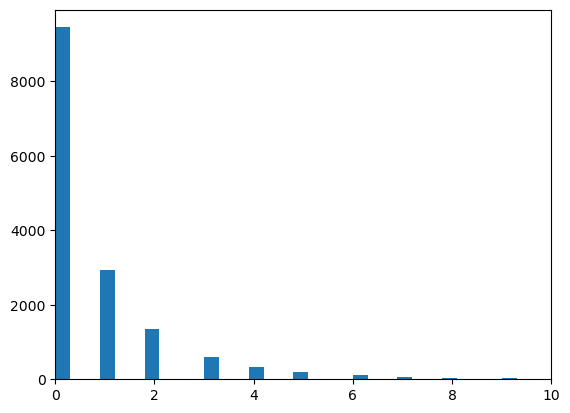

In [44]:
plt.hist(MaxN,bins=100)
plt.xlim(0,10);

In [45]:
nlocs

58

In [46]:
NSamples = 5000

In [47]:
NPR = 3
NPR_z = 3

### Hierarchical full model

In [48]:
with pm.Model() as ZINB_full:
    # = = = = = = = = = = = COUNTS = = = = = = = = = = = = = = #
    # Global count model
    π0 = pm.Normal('Global_rate', 0, NPR)
    σ0_υ = pm.Uniform('σ0_υ', 0, 10)
    pi_tilde = pm.Normal('pi_t', 0, 1, shape=nreg)
    υ0 = pm.Deterministic('Regional_rate', π0 + σ0_υ*pi_tilde)

    # National count model
    η2 = pm.Normal('Sanctuary', 0, NPR)
    η3 = pm.Normal('CoastLength', 0, NPR)
    
    η = υ0[Ig]+η2*SSA+η3*CLN
    σ0_η = pm.Uniform('σ0_η', 0, 10)
    η0 = pm.Normal('η0', η, σ0_η, shape=nlocs)
    
    # Reef-level count model
    κ1_ = pm.Normal('Reef_type', 0, NPR, shape=nrty-1)
    κ1 = pm.math.concatenate([np.zeros(1), κ1_])
    
    κ3 = pm.Normal('Closed', 0, NPR)
    κ3a = pm.Normal('MPA_size', 0, NPR)
    κ3b = pm.Normal('High_compliance', 0, NPR)
    
    κ4 = pm.Normal('Gillnet_longline', 0, NPR)
    κ5 = pm.Normal('Drumline', 0, NPR)
    κ6 = pm.Normal('HookLine', 0, NPR)
    
    κ7 = pm.Normal('Catch', 0, NPR)
    κ7b = pm.Normal('Temporal', 0, NPR)
    κ7c = pm.Normal('Species', 0, NPR)
    
    κ8 = pm.Normal('Remote', 0, NPR)
    κ9 = pm.Normal('Gravity_NP', 0, NPR)
    κ10 = pm.Normal('Gravity_NC', 0, NPR)
    
    # Reef model
    κ = η0[Ilr]+κ1[Irty]+κ3*CLO+κ3a*MPS+κ3b*HIG+κ4*GILL+κ5*DRUM+κ6*HLIN+κ7*BAG+κ7b*TEM+κ7c*SPP+κ8*REM+κ9*GRAV+κ10*GRAV_NC
    
    σ0_κ = pm.Uniform('σ0_κ',0 , 100)
    κ0 = pm.Normal('κ0', κ, σ0_κ, shape=nreefs)

    # = = = Observation model
    ρ1 = pm.Normal('Depth', 0, NPR)
    
    ρ4 = pm.Normal('Visibililty', 0, NPR)
    ρ5 = pm.Normal('Hard_coral', 0, NPR)
    ρ6 = pm.Normal('Rugosity', 0, NPR)
    ρ7 = pm.Normal('TimeODay', 0, NPR)
    ρ8_ = pm.Normal('Bait_type', 0, NPR, shape=nbait-1)
    ρ8 = pm.math.concatenate([np.zeros(1), ρ8_])
    ρ9_ = pm.Normal('Seasonality', 0, NPR, shape=nsea-1)
    ρ9 = pm.math.concatenate([np.zeros(1), ρ9_])
    
    μ_ = κ0[Ir]+ρ1*DEPTH+ρ4*VIS+ρ5*HC+ρ6*RUG+ρ7*DAY+ρ8[Ib]+ρ9[Ic]

    μ = pm.math.exp(μ_)
    
    # = = = = = = = = = = = ZEROS = = = = = = = = = = = = = = #
    # Global zeros model
    π0_z = pm.Cauchy('Global_zeros', 0, 10)
    σ0_υ_z = pm.Exponential('σ0_υ_z', .5)
    pi0_tilde = pm.Normal('pi0_t', 0, 1, shape=nreg)
    υ0_z = pm.Deterministic('Regional_zeros', π0_z + σ0_υ_z*pi0_tilde)
    σ0_η_z = pm.Exponential('σ0_η_z', .5)

    # National zeros model
    η1_z = pm.Cauchy('HDI', 0, NPR)
    η2_z = pm.Cauchy('VOICE', 0, NPR)
    η3_z = pm.Cauchy('POP', 0, NPR)
    η_z = υ0_z[Ig]+η1_z*HDI+η2_z*VOICE+η3_z*POP
    η0_z = pm.Normal('η0_z', η_z, σ0_η_z, shape=nlocs)
    
    # Proportion of non-zeros
    ψ = pm.invlogit(η0_z[Ils])

    # = = = = = = = = = = = Likelihood = = = = = = = = = = = = = = #
    α = pm.Gamma('alpha', 0.001, 0.001)
    Yi = pm.ZeroInflatedNegativeBinomial('Yi', ψ, μ, α, observed=MaxN)


In [49]:
# Sampling
with ZINB_full:
    ZINB_full_trace = pm.sample(1000, target_accept=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Global_rate, σ0_υ, pi_t, Sanctuary, CoastLength, σ0_η, η0, Reef_type, Closed, MPA_size, High_compliance, Gillnet_longline, Drumline, HookLine, Catch, Temporal, Species, Remote, Gravity_NP, Gravity_NC, σ0_κ, κ0, Depth, Visibililty, Hard_coral, Rugosity, TimeODay, Bait_type, Seasonality, Global_zeros, σ0_υ_z, pi0_t, σ0_η_z, HDI, VOICE, POP, η0_z, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1165 seconds.


/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (40), generating only 20 plots
  warnings.warn(


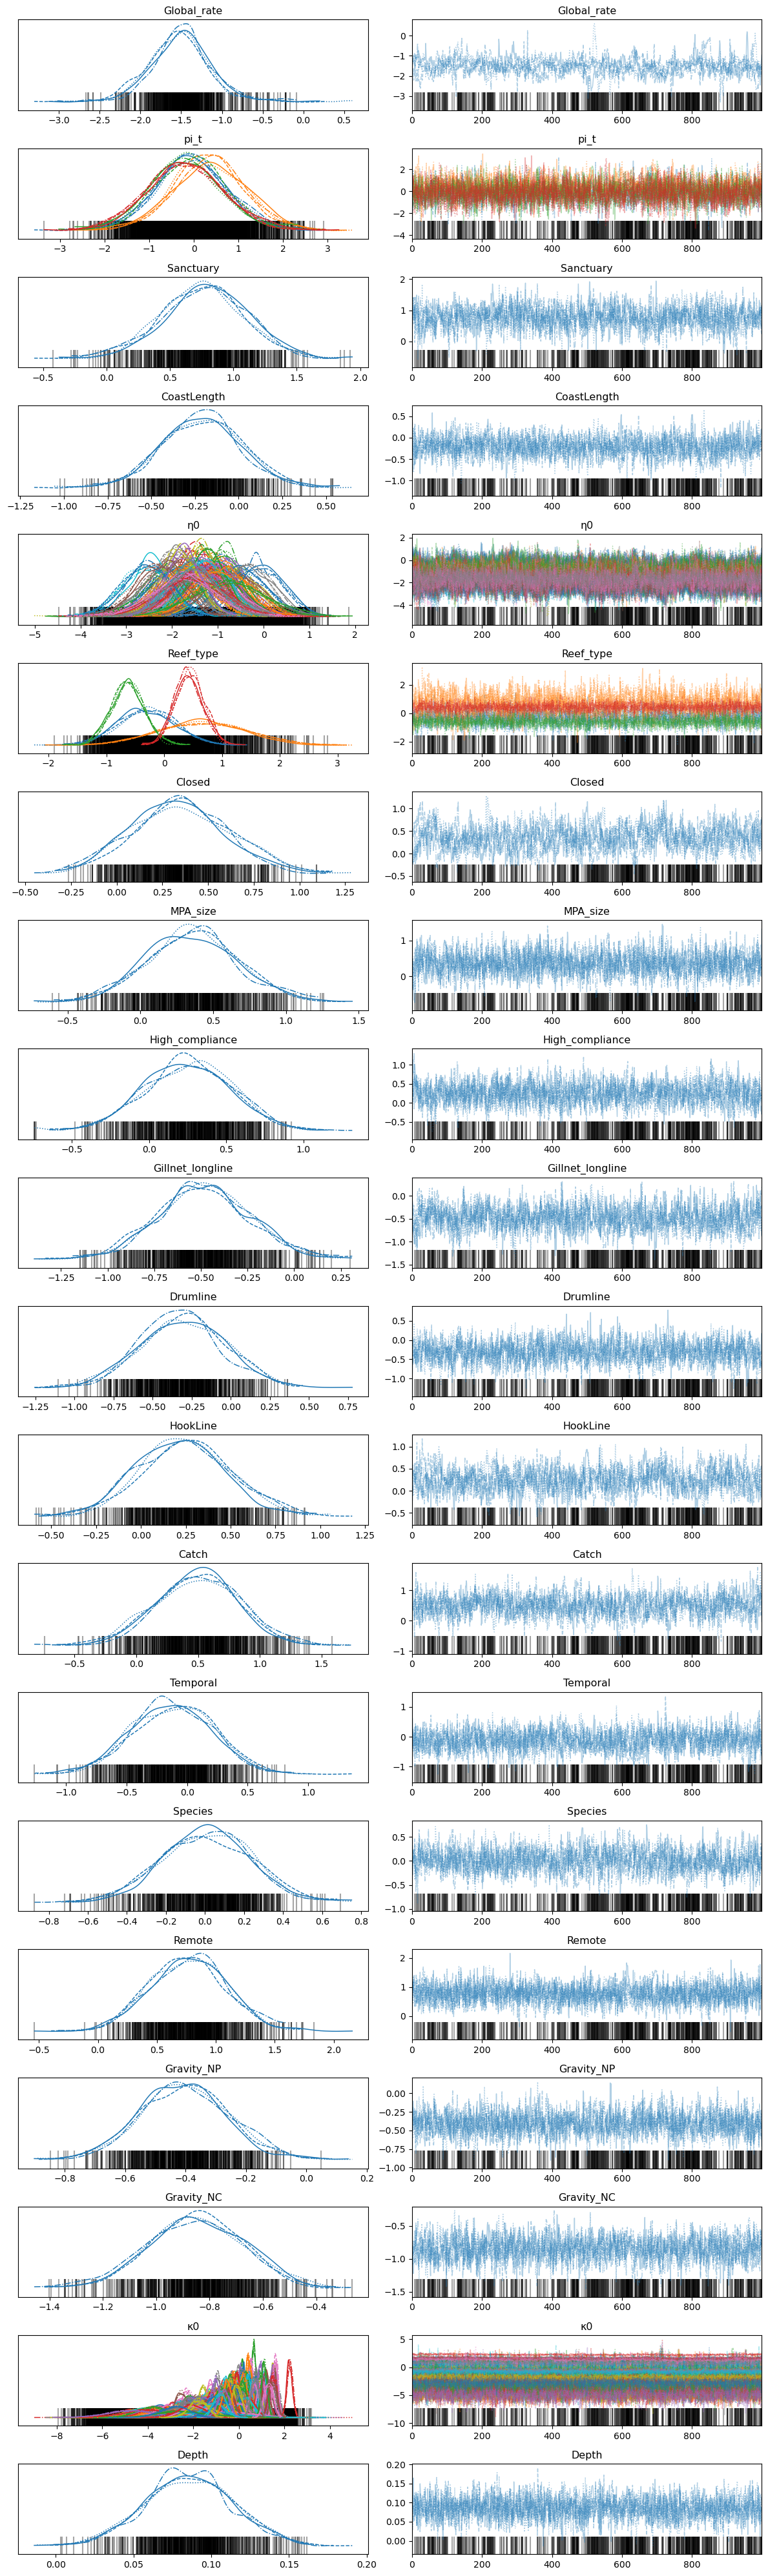

In [50]:
pm.plot_trace(ZINB_full_trace)
plt.tight_layout();

### Counterfactual models

In [51]:
# Empty matrix for predicted values using values
n = 1000
ynew = np.zeros((n,nobs))

In [52]:
# loop over 
for i in range(n):
    # = = = = = = = = = = = COUNTS = = = = = = = = = = = = = = #
    # Global count model
    π0 = np.random.choice(ZINB_full_trace.posterior["Global_rate"].values.flatten())
    σ0_υ = np.random.choice(ZINB_full_trace.posterior["σ0_υ"].values.flatten())
    pi_tilde = np.random.choice(ZINB_full_trace.posterior["pi_t"].values.flatten(),nreg)
    υ0 = π0 + σ0_υ*pi_tilde

    # National count model
    η2 = np.random.choice(ZINB_full_trace.posterior["Sanctuary"].values.flatten())
    η3 = np.random.choice(ZINB_full_trace.posterior["CoastLength"].values.flatten())
    
    η = υ0[Ig]+η2*SSA+η3*CLN
    σ0_η = np.random.choice(ZINB_full_trace.posterior["σ0_η"].values.flatten())
    η0 = pm.Normal.dist(η, σ0_η, shape=nlocs)
    
    # Reef-level count model
    κ1_ = np.random.choice(ZINB_full_trace.posterior["Reef_type"].values.flatten(),nrty-1)
    κ1 = np.concatenate([np.zeros(1), κ1_])
    
    κ3 = np.random.choice(ZINB_full_trace.posterior["Closed"].values.flatten())
    κ3a = np.random.choice(ZINB_full_trace.posterior["MPA_size"].values.flatten())
    κ3b = np.random.choice(ZINB_full_trace.posterior["High_compliance"].values.flatten())
    
    κ4 = np.random.choice(ZINB_full_trace.posterior["Gillnet_longline"].values.flatten())
    κ5 = np.random.choice(ZINB_full_trace.posterior["Drumline"].values.flatten())
    κ6 = np.random.choice(ZINB_full_trace.posterior["HookLine"].values.flatten())
    
    κ7 = np.random.choice(ZINB_full_trace.posterior["Catch"].values.flatten())
    κ7b = np.random.choice(ZINB_full_trace.posterior["Temporal"].values.flatten())
    κ7c = np.random.choice(ZINB_full_trace.posterior["Species"].values.flatten())
    
    κ8 = np.random.choice(ZINB_full_trace.posterior["Remote"].values.flatten())
    κ9 = np.random.choice(ZINB_full_trace.posterior["Gravity_NP"].values.flatten())
    κ10 = np.random.choice(ZINB_full_trace.posterior["Gravity_NC"].values.flatten())
    
    # Reef model
    κ = η0[Ilr]+κ1[Irty]+κ3*CLO+κ3a*MPS+κ3b*HIG+κ4*GILL+κ5*DRUM+κ6*HLIN+κ7*BAG+κ7b*TEM+κ7c*SPP+κ8*REM+κ9*GRAV+κ10*GRAV_NC
    
    σ0_κ = np.random.choice(ZINB_full_trace.posterior["σ0_κ"].values.flatten())
    κ0 = pm.Normal.dist(κ, σ0_κ, shape=nreefs)

    # = = = Observation model
    ρ1 = np.random.choice(ZINB_full_trace.posterior["Depth"].values.flatten())
    
    ρ4 = np.random.choice(ZINB_full_trace.posterior["Visibililty"].values.flatten())
    ρ5 = np.random.choice(ZINB_full_trace.posterior["Hard_coral"].values.flatten())
    ρ6 = np.random.choice(ZINB_full_trace.posterior["Rugosity"].values.flatten())
    ρ7 = np.random.choice(ZINB_full_trace.posterior["TimeODay"].values.flatten())
    ρ8_ = np.random.choice(ZINB_full_trace.posterior["Bait_type"].values.flatten(),nbait-1)
    ρ8 = np.concatenate([np.zeros(1), ρ8_])
    ρ9_ = np.random.choice(ZINB_full_trace.posterior["Seasonality"].values.flatten(),nsea-1)
    ρ9 = np.concatenate([np.zeros(1), ρ9_])
    
    μ_ = κ0[Ir]+ρ1*DEPTH+ρ4*VIS+ρ5*HC+ρ6*RUG+ρ7*DAY+ρ8[Ib]+ρ9[Ic]

    μ = np.exp(μ_)
    
    # = = = = = = = = = = = ZEROS = = = = = = = = = = = = = = #
    # Global zeros model
    π0_z = np.random.choice(ZINB_full_trace.posterior["Global_zeros"].values.flatten())
    σ0_υ_z = np.random.choice(ZINB_full_trace.posterior["σ0_υ_z"].values.flatten())
    pi0_tilde = np.random.choice(ZINB_full_trace.posterior["pi0_t"].values.flatten(),nreg)
    υ0_z = π0_z + σ0_υ_z*pi0_tilde
    σ0_η_z = np.random.choice(ZINB_full_trace.posterior["σ0_η_z"].values.flatten())

    # National zeros model
    η1_z = np.random.choice(ZINB_full_trace.posterior["HDI"].values.flatten())
    η2_z = np.random.choice(ZINB_full_trace.posterior["VOICE"].values.flatten())
    η3_z = np.random.choice(ZINB_full_trace.posterior["POP"].values.flatten())
    η_z = υ0_z[Ig]+η1_z*HDI+η2_z*VOICE+η3_z*POP
    #η0_z = np.random.choice(ZINB_full_trace.posterior["η0_z"].values.flatten(),nlocs)
    η0_z = pm.Normal.dist(η_z, σ0_η_z, shape=nlocs)
    
    # Proportion of non-zeros
    ψ = invlogit(η0_z[Ils]) # might get error with this - if it doesnt work, try:
    # np.array([invlogit(x) for x in η0[Ilr]])
    
    # = = = = = = = = = = = Likelihood = = = = = = = = = = = = = = #
    α = np.random.choice(ZINB_full_trace.posterior["alpha"].values.flatten())
    ynew[i,] = pm.ZeroInflatedNegativeBinomial.dist(ψ, μ, α).eval()
    

In [53]:
np.mean(ynew)

1.4884260468183317

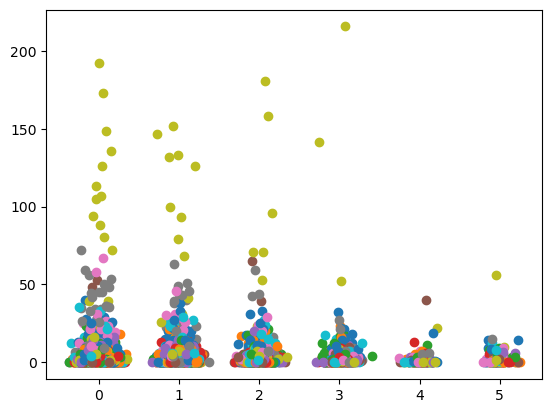

In [54]:
for i in range(100):
    [plt.scatter(MaxN[i]+np.random.normal(0,0.1),y+np.random.normal(0,0.1)) for y in ynew.T[i,:100]]

In [55]:
# Counterfacual variables
mean_Grav_NP = np.mean(np.log(xdata.Grav_NP.values[rkey]+1))
sd_Grav_NP = np.std(np.log(xdata.Grav_NP.values[rkey]+1))
GRAV_new = (np.log(0+1)-mean_Grav_NP)/(sd_Grav_NP*2)

mean_Grav_NC = np.mean(np.log(xdata.Grav_NC.values[rkey]+1))
sd_Grav_NC = np.std(np.log(xdata.Grav_NC.values[rkey]+1))
GRAV_NC_new = (np.log(0+1)-mean_Grav_NC)/(sd_Grav_NC*2)

mean_Pop = np.mean(np.log(ldata.Population.values[lkey]))
sd_Pop = np.std(np.log(ldata.Population.values[lkey]))
POP_new = (np.log(0+1)-mean_Pop)/(sd_Pop*2)

MPSx = xdata.mpa_area.fillna(-999).values[rkey]
tmp = MPSx!=-999
perc = np.percentile(MPSx[tmp],75) # Set to 75th percentile
max_val = max(np.log(MPSx[tmp]+1))

MPS_new = np.log(perc+1)/max_val

SSA_new = 1
CLO_new = 1
HIG_new = 1
GILL_new = 0
DRUM_new = 0
HLIN_new = 0
BAG_new = 1
TEM_new = 1
SPP_new = 1
REM_new = 1
HDI_new = 1
VOICE_new = 2.5 

In [56]:
# Empty matrix for predicted values
ynewa = np.zeros((n,nobs))

In [57]:
# loop over 
for i in range(n):
    # = = = = = = = = = = = COUNTS = = = = = = = = = = = = = = #
    # Global count model
    π0 = np.random.choice(ZINB_full_trace.posterior["Global_rate"].values.flatten())
    σ0_υ = np.random.choice(ZINB_full_trace.posterior["σ0_υ"].values.flatten())
    pi_tilde = np.random.choice(ZINB_full_trace.posterior["pi_t"].values.flatten(),nreg)
    υ0 = π0 + σ0_υ*pi_tilde

    # National count model
    η2 = np.random.choice(ZINB_full_trace.posterior["Sanctuary"].values.flatten())
    η3 = np.random.choice(ZINB_full_trace.posterior["CoastLength"].values.flatten())
    
    η = υ0[Ig]+η2*SSA_new+η3*CLN
    σ0_η = np.random.choice(ZINB_full_trace.posterior["σ0_η"].values.flatten())
    η0 = pm.Normal.dist(η, σ0_η, shape=nlocs)
    
    # Reef-level count model
    κ1_ = np.random.choice(ZINB_full_trace.posterior["Reef_type"].values.flatten(),nrty-1)
    κ1 = np.concatenate([np.zeros(1), κ1_])
    
    κ3 = np.random.choice(ZINB_full_trace.posterior["Closed"].values.flatten())
    κ3a = np.random.choice(ZINB_full_trace.posterior["MPA_size"].values.flatten())
    κ3b = np.random.choice(ZINB_full_trace.posterior["High_compliance"].values.flatten())
    
    κ4 = np.random.choice(ZINB_full_trace.posterior["Gillnet_longline"].values.flatten())
    κ5 = np.random.choice(ZINB_full_trace.posterior["Drumline"].values.flatten())
    κ6 = np.random.choice(ZINB_full_trace.posterior["HookLine"].values.flatten())
    
    κ7 = np.random.choice(ZINB_full_trace.posterior["Catch"].values.flatten())
    κ7b = np.random.choice(ZINB_full_trace.posterior["Temporal"].values.flatten())
    κ7c = np.random.choice(ZINB_full_trace.posterior["Species"].values.flatten())
    
    κ8 = np.random.choice(ZINB_full_trace.posterior["Remote"].values.flatten())
    κ9 = np.random.choice(ZINB_full_trace.posterior["Gravity_NP"].values.flatten())
    κ10 = np.random.choice(ZINB_full_trace.posterior["Gravity_NC"].values.flatten())
    
    # Reef model
    κ = η0[Ilr]+κ1[Irty]+κ3*CLO_new+κ3a*MPS_new+κ3b*HIG_new+κ4*GILL_new+κ5*DRUM_new+κ6*HLIN_new+κ7*BAG_new+κ7b*TEM_new+κ7c*SPP_new+κ8*REM_new+κ9*GRAV_new+κ10*GRAV_NC_new
    
    σ0_κ = np.random.choice(ZINB_full_trace.posterior["σ0_κ"].values.flatten())
    κ0 = pm.Normal.dist(κ, σ0_κ, shape=nreefs)

    # = = = Observation model
    ρ1 = np.random.choice(ZINB_full_trace.posterior["Depth"].values.flatten())
    
    ρ4 = np.random.choice(ZINB_full_trace.posterior["Visibililty"].values.flatten())
    ρ5 = np.random.choice(ZINB_full_trace.posterior["Hard_coral"].values.flatten())
    ρ6 = np.random.choice(ZINB_full_trace.posterior["Rugosity"].values.flatten())
    ρ7 = np.random.choice(ZINB_full_trace.posterior["TimeODay"].values.flatten())
    ρ8_ = np.random.choice(ZINB_full_trace.posterior["Bait_type"].values.flatten(),nbait-1)
    ρ8 = np.concatenate([np.zeros(1), ρ8_])
    ρ9_ = np.random.choice(ZINB_full_trace.posterior["Seasonality"].values.flatten(),nsea-1)
    ρ9 = np.concatenate([np.zeros(1), ρ9_])
    
    μ_ = κ0[Ir]+ρ1*DEPTH+ρ4*VIS+ρ5*HC+ρ6*RUG+ρ7*DAY+ρ8[Ib]+ρ9[Ic]

    μ = np.exp(μ_)
    
    # = = = = = = = = = = = ZEROS = = = = = = = = = = = = = = #
    # Global zeros model
    π0_z = np.random.choice(ZINB_full_trace.posterior["Global_zeros"].values.flatten())
    σ0_υ_z = np.random.choice(ZINB_full_trace.posterior["σ0_υ_z"].values.flatten())
    pi0_tilde = np.random.choice(ZINB_full_trace.posterior["pi0_t"].values.flatten(),nreg)
    υ0_z = π0_z + σ0_υ_z*pi0_tilde
    σ0_η_z = np.random.choice(ZINB_full_trace.posterior["σ0_η_z"].values.flatten())

    # National zeros model
    η1_z = np.random.choice(ZINB_full_trace.posterior["HDI"].values.flatten())
    η2_z = np.random.choice(ZINB_full_trace.posterior["VOICE"].values.flatten())
    η3_z = np.random.choice(ZINB_full_trace.posterior["POP"].values.flatten())
    η_z = υ0_z[Ig]+η1_z*HDI_new+η2_z*VOICE_new+η3_z*POP_new
    η0_z = pm.Normal.dist(η_z, σ0_η_z, shape=nlocs)
    
    # Proportion of non-zeros
    ψ = invlogit(η0_z[Ils])
    
    # = = = = = = = = = = = Likelihood = = = = = = = = = = = = = = #
    α = np.random.choice(ZINB_full_trace.posterior["alpha"].values.flatten())
    ynewa[i,] = pm.ZeroInflatedNegativeBinomial.dist(ψ, μ, α).eval()
    

In [58]:
np.median(ynewa,0)

array([3., 4., 3., ..., 4., 2., 3.])

In [59]:
tmp = np.median(ynewa,0) - np.median(ynew,0)

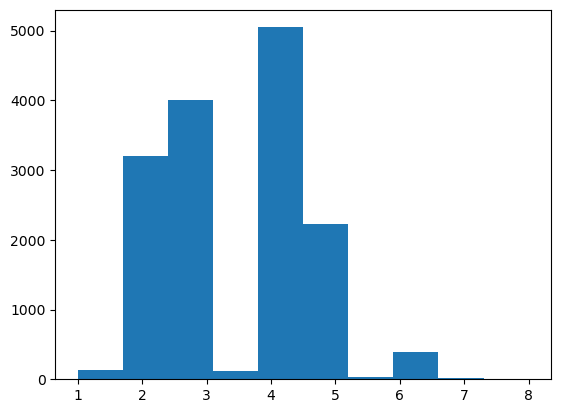

In [61]:
plt.hist(tmp);

In [62]:
dif = np.ones((nreefs))*-999

In [63]:
for i in range(nreefs):
    dif[i] = np.mean(tmp[Ir==i])

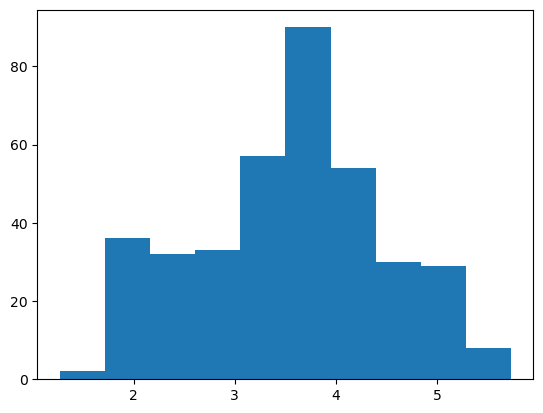

In [64]:
plt.hist(dif); # Difference in expected MaxN betewen human and non-human scenarios

In [65]:
#np.savetxt("maxndifference.csv", dif, delimiter=",")

In [66]:
xynewa = np.median(ynewa,0)

In [67]:
non = np.ones((nreefs))*-999

In [68]:
for i in range (nreefs):
    non[i] = np.mean(xynewa[Ir==i])

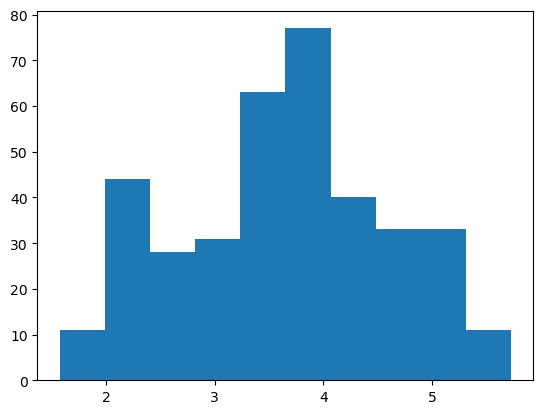

In [69]:
plt.hist(non);

In [70]:
#np.savetxt("nohumansmaxn.csv", non, delimiter=",")

In [71]:
xynew = np.mean(ynew,0)

In [72]:
hum = np.ones((nreefs))*-999

In [73]:
for i in range (nreefs):
    hum[i] = np.mean(xynew[Ir==i])

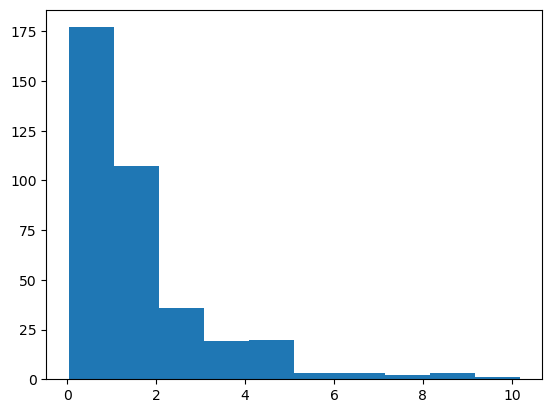

In [74]:
plt.hist(hum);

In [75]:
#np.savetxt("humansmaxn.csv", hum, delimiter=",")